In [1]:

import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:

# service that returns IP address in a JSON
import requests
r = requests.get('https://api.ipify.org?format=json')
j = r.json()
print(j)

# This Tensorflow model server is the same, except what it does is much more
# complex as it returns the predictions from a ML model

{'ip': '35.187.153.93'}


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model

In [4]:
# Load in the data
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
print("x_train.shape:", x_train.shape)
print("x_test.shape:", x_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
x_train.shape: (60000, 28, 28)
x_test.shape: (10000, 28, 28)


In [5]:

# convolution expects height x width x color
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print(x_train.shape)

(60000, 28, 28, 1)


In [6]:
# number of classes
K = len(set(y_train))
print("number of classes:", K)

number of classes: 10


In [7]:
# Build the model using the functional API
i = Input(shape=x_train[0].shape)
x = Conv2D(32, (3, 3), strides=2, activation='relu')(i)
x = Conv2D(64, (3, 3), strides=2, activation='relu')(x)
x = Conv2D(128, (3, 3), strides=2, activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(K, activation='softmax')(x)

model = Model(i, x)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 13, 13, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)              

In [8]:
# Compile and fit
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
r = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15)

Epoch 1/15
1875/1875 [==============================] - 10s 5ms/step - loss: 0.5127 - accuracy: 0.8094 - val_loss: 0.3831 - val_accuracy: 0.8583
Epoch 2/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3536 - accuracy: 0.8672 - val_loss: 0.3388 - val_accuracy: 0.8728
Epoch 3/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3031 - accuracy: 0.8863 - val_loss: 0.3251 - val_accuracy: 0.8803
Epoch 4/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2739 - accuracy: 0.8978 - val_loss: 0.3033 - val_accuracy: 0.8887
Epoch 5/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2527 - accuracy: 0.9060 - val_loss: 0.2960 - val_accuracy: 0.8924
Epoch 6/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2305 - accuracy: 0.9130 - val_loss: 0.2949 - val_accuracy: 0.8943
Epoch 7/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2128 - accuracy: 0.9193 - val_loss: 0.2924 - val_accuracy

In [9]:
# Save the model to a temporary directory
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
if os.path.isdir(export_path):
  print('\nAlready saved a model, cleaning up\n')
  !rm -r {export_path}

tf.saved_model.save(model, export_path)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/1/assets

Saved model:
total 168
drwxr-xr-x 2 root root   4096 Sep  2 10:45 assets
-rw-r--r-- 1 root root 161430 Sep  2 10:45 saved_model.pb
drwxr-xr-x 2 root root   4096 Sep  2 10:45 variables


In [10]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
W0902 10:45:20.626708 140268347709312 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/ops/re

In [11]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# So in the CMD it would be : 
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  11063      0 --:--:-- --:--:-- --:--:-- 11022
OK
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [95.7 kB]
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:8 https://devel

In [12]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 62 not upgraded.
Need to get 210 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.3.0 [210 MB]
Fetched 210 MB in 4s (48.0 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 144579 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.3.0_all.deb ...
Unpacking tensorflow-model-server (2.3.0) ...
Setting up tensorflow-model-server (2.3.0) ...


In [13]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [14]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [15]:
!tail server.log

2020-09-02 10:45:41.595672: I tensorflow_serving/model_servers/server_core.cc:464] Adding/updating models.
2020-09-02 10:45:41.595717: I tensorflow_serving/model_servers/server_core.cc:575]  (Re-)adding model: fashion_model
2020-09-02 10:45:41.597738: I tensorflow_serving/core/basic_manager.cc:739] Successfully reserved resources to load servable {name: fashion_model version: 1}
2020-09-02 10:45:41.597775: I tensorflow_serving/core/loader_harness.cc:66] Approving load for servable version {name: fashion_model version: 1}
2020-09-02 10:45:41.597796: I tensorflow_serving/core/loader_harness.cc:74] Loading servable version {name: fashion_model version: 1}
2020-09-02 10:45:41.597850: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:31] Reading SavedModel from: /tmp/1
2020-09-02 10:45:41.601278: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:54] Reading meta graph with tags { serve }
2020-09-02 10:45:41.601318: I external/org_tensorflow/tensorflow/cc/saved_model/

In [16]:
# Label mapping
labels = '''T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot'''.split("\n")

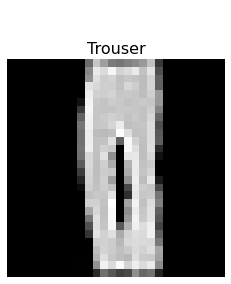

In [17]:
def show(idx, title):
  plt.figure()
  plt.imshow(x_test[idx].reshape(28,28), cmap='gray')
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

i = np.random.randint(0, len(x_test))
show(i, labels[y_test[i]])

In [18]:

import json
data = json.dumps({"signature_name": "serving_default", "instances": x_test[0:3].tolist()})
print(data)

{"signature_name": "serving_default", "instances": [[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], 

In [19]:
headers = {"content-type": "application/json"}
r = requests.post('http://localhost:8501/v1/models/fashion_model:predict', data=data, headers=headers)
j = r.json()
print(j.keys())
print(j)

dict_keys(['predictions'])
{'predictions': [[5.00102313e-14, 2.97286495e-17, 2.10975128e-16, 3.13439592e-16, 1.06156257e-15, 9.17461772e-14, 2.15526517e-15, 1.72510148e-08, 4.65423217e-15, 1.0], [1.35685696e-09, 3.16170961e-12, 0.999999762, 1.48365757e-07, 1.10109994e-07, 1.28074624e-17, 1.40585579e-08, 1.63923872e-15, 6.79534079e-14, 5.35992523e-17], [2.14104231e-20, 1.0, 2.7211287e-27, 4.18423223e-24, 2.79937104e-25, 0.0, 4.81323136e-31, 0.0, 2.26101636e-31, 1.29821154e-35]]}


In [20]:

pred = np.array(j['predictions'])
print(pred.shape)
# This is the N x K output array from the model
# pred[n,k] is the probability that the nth sample belongs to the kth class

(3, 10)


In [21]:
# Get the predicted classes
pred = pred.argmax(axis=1)

In [22]:
# Map them back to strings
pred = [labels[i] for i in pred]
print(pred)

['Ankle boot', 'Pullover', 'Trouser']


In [23]:
# Get the true labels
actual = [labels[i] for i in y_test[:3]]
print(actual)

['Ankle boot', 'Pullover', 'Trouser']


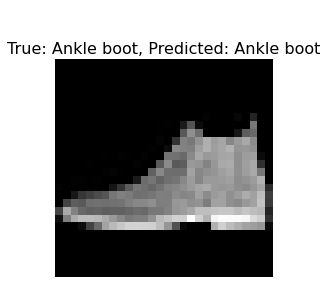

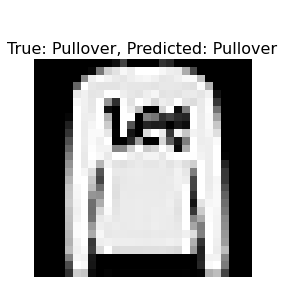

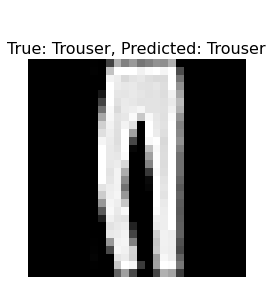

In [24]:
for i in range(0,3):
  show(i, f"True: {actual[i]}, Predicted: {pred[i]}")

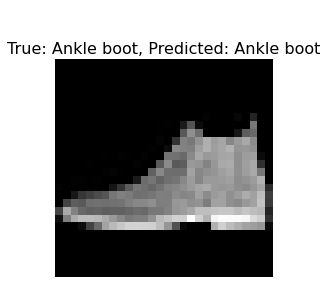

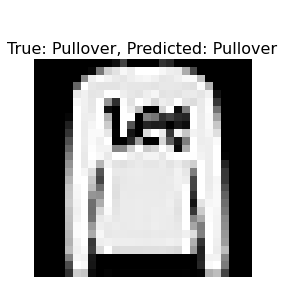

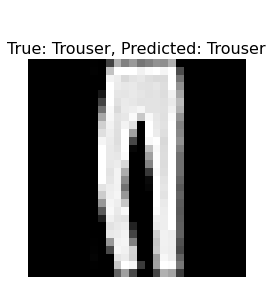

In [25]:
#select a model by version

headers = {"content-type": "application/json"}
r = requests.post('http://localhost:8501/v1/models/fashion_model/versions/1:predict', data=data, headers=headers)
j = r.json()
pred = np.array(j['predictions'])
pred = pred.argmax(axis=1)
pred = [labels[i] for i in pred]
for i in range(0,3):
  show(i, f"True: {actual[i]}, Predicted: {pred[i]}")

In [26]:
#New model
i = Input(shape=x_train[0].shape)
x = Conv2D(32, (3, 3), strides=2, activation='relu')(i)
x = Flatten()(x)
x = Dense(K, activation='softmax')(x)

model2 = Model(i, x)
model2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 32)        320       
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Compile and fit
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
r = model2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15)

Epoch 1/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4579 - accuracy: 0.8390 - val_loss: 0.3615 - val_accuracy: 0.8719
Epoch 2/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3205 - accuracy: 0.8865 - val_loss: 0.3323 - val_accuracy: 0.8817
Epoch 3/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2865 - accuracy: 0.8972 - val_loss: 0.3135 - val_accuracy: 0.8877
Epoch 4/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2666 - accuracy: 0.9043 - val_loss: 0.3100 - val_accuracy: 0.8864
Epoch 5/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2504 - accuracy: 0.9097 - val_loss: 0.3147 - val_accuracy: 0.8852
Epoch 6/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2380 - accuracy: 0.9134 - val_loss: 0.2950 - val_accuracy: 0.8960
Epoch 7/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2275 - accuracy: 0.9179 - val_loss: 0.2953 - val_accuracy:

In [28]:
# Save this as version 2 of the model
version = 2
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
if os.path.isdir(export_path):
  print('\nAlready saved a model, cleaning up\n')
  !rm -r {export_path}

tf.saved_model.save(model2, export_path)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/2

INFO:tensorflow:Assets written to: /tmp/2/assets

Saved model:
total 84
drwxr-xr-x 2 root root  4096 Sep  2 10:47 assets
-rw-r--r-- 1 root root 76237 Sep  2 10:47 saved_model.pb
drwxr-xr-x 2 root root  4096 Sep  2 10:47 variables


In [29]:

headers = {"content-type": "application/json"}
r = requests.post('http://localhost:8501/v1/models/fashion_model/versions/2:predict', data=data, headers=headers)
j = r.json()
pred = np.array(j['predictions'])
pred = pred.argmax(axis=1)
pred = [labels[i] for i in pred]
for i in range(0,3):
  show(i, f"True: {actual[i]}, Predicted: {pred[i]}")

KeyError: ignored

In [ ]:
#If there is no version that exists then it will throw an error
headers = {"content-type": "application/json"}
r = requests.post('http://localhost:8501/v1/models/fashion_model/versions/3:predict', data=data, headers=headers)
j = r.json()
print(j)